In [1]:
from training_defs import load_data, train_model


#Loading training, validating, testing data sets
train_loader, val_loader, test_loader, scaler = load_data(
    csv_path="simpler_data_rwc.csv",
    test_size=0.2,    # 20% for validation
    batch_size=32     # Process 32 samples at a time
    )
dataset_size = len(train_loader) + len(val_loader)+len(test_loader)
print(f"Training: {len(train_loader)/dataset_size * 100:.2f}%")
print(f"Validating: {len(val_loader)/dataset_size * 100:.2f}%")
print(f"Testing: {len(test_loader)/dataset_size * 100:.2f}%")


Training: 78.57%
Validating: 10.71%
Testing: 10.71%


Training MLP: 210 → 64 → 3
Epoch  1: Train=0.4509, Val=0.2161
Epoch  2: Train=0.1746, Val=0.1330
Epoch  3: Train=0.0970, Val=0.0616
Epoch  4: Train=0.0758, Val=0.1082
Epoch  5: Train=0.0754, Val=0.0855
Epoch  6: Train=0.0653, Val=0.0426
Epoch  7: Train=0.0572, Val=0.0601
Epoch  8: Train=0.0473, Val=0.0516
Epoch  9: Train=0.0479, Val=0.0500
Epoch 10: Train=0.0463, Val=0.0440
Epoch 11: Train=0.0402, Val=0.0537
Epoch 12: Train=0.0425, Val=0.0460
Epoch 13: Train=0.0387, Val=0.0258
Epoch 14: Train=0.0298, Val=0.0311
Epoch 15: Train=0.0349, Val=0.0278
Epoch 16: Train=0.0282, Val=0.0262
Epoch 17: Train=0.0345, Val=0.0232
Epoch 18: Train=0.0308, Val=0.0258
Epoch 19: Train=0.0305, Val=0.0281
Epoch 20: Train=0.0313, Val=0.0266
Epoch 21: Train=0.0289, Val=0.0290
Epoch 22: Train=0.0302, Val=0.0284
Epoch 23: Train=0.0275, Val=0.0226
Epoch 24: Train=0.0276, Val=0.0202
Epoch 25: Train=0.0279, Val=0.0197
Epoch 26: Train=0.0282, Val=0.0236
Epoch 27: Train=0.0257, Val=0.0222
Epoch 28: Train=0.0276, Val=

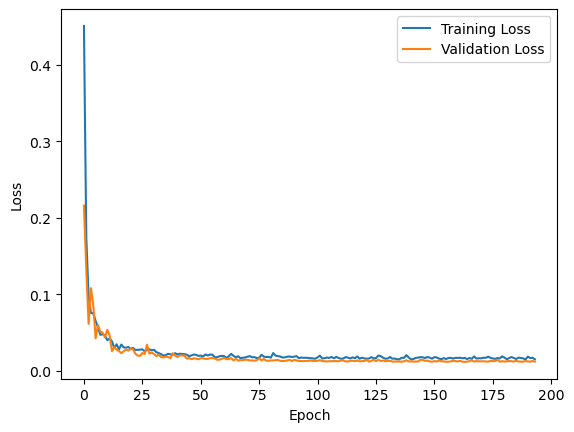

In [2]:
import matplotlib.pyplot as plt
from training_defs import train_model

# Use your current parameters - the logic is now fixed!
model, scaler, losses = train_model(
    input_size=210,      # Match your data
    hidden_sizes=[64],   # Your current size (now as list)
    learning_rate=0.01, # Your current rate
    num_epochs=200,       # More epochs since learning was broken before
    patience=30
)

plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [3]:
# Architecture Comparison: Training Different Network Sizes
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from training_defs import train_model, load_data
from model import MLP
import time

print("🏗️ Architecture Comparison: Different Network Sizes")
print("=" * 60)

# Define architectures to test
architectures = {
    "128-128-3": [128, 128],
    "128-256-256-128-3": [128, 256, 256, 128], 
    "256-256-256-256-3": [256, 256, 256, 256]
}

# Store results for comparison
results = {}
training_times = {}

# Train each architecture
for arch_name, hidden_sizes in architectures.items():
    print(f"\n🚀 Training Architecture: {arch_name}")
    print("-" * 40)
    
    start_time = time.time()
    
    # Train the model
    model, scaler, losses = train_model(
        input_size=210,
        hidden_sizes=hidden_sizes,
        dropout_rate=0.2,
        learning_rate=0.01,
        num_epochs=150,  # Reasonable number for comparison
        patience=25,
        lambda_weight=1.0
    )
    
    training_time = time.time() - start_time
    training_times[arch_name] = training_time
    
    print(f"⏱️ Training completed in {training_time:.1f} seconds")
    
    # Evaluate on test set
    _, _, test_loader, _ = load_data()
    
    # Collect predictions and targets
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for X, y in test_loader:
            pred = model(X)
            all_predictions.append(pred.numpy())
            all_targets.append(y.numpy())
    
    # Concatenate all batches
    y_pred = np.concatenate(all_predictions, axis=0)
    y_true = np.concatenate(all_targets, axis=0)
    
    # Calculate metrics for each fraction
    fraction_names = ['Green Vegetation (GV)', 'Non-Photosynthetic Vegetation (NPV)', 'Soil']
    fraction_metrics = {}
    
    for i, name in enumerate(fraction_names):
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        
        fraction_metrics[name] = {
            'mse': mse,
            'mae': mae, 
            'rmse': rmse,
            'r2': r2
        }
    
    # Overall metrics
    overall_mse = mean_squared_error(y_true, y_pred)
    overall_mae = mean_absolute_error(y_true, y_pred)
    overall_r2 = r2_score(y_true, y_pred)
    
    # Calculate abundance sum constraint violation
    abundance_sum = np.sum(y_pred, axis=1)
    constraint_violation = np.mean(np.abs(1.0 - abundance_sum))
    
    # Store results
    results[arch_name] = {
        'fraction_metrics': fraction_metrics,
        'overall_mse': overall_mse,
        'overall_mae': overall_mae,
        'overall_r2': overall_r2,
        'constraint_violation': constraint_violation,
        'final_train_loss': losses['train'][-1],
        'final_val_loss': losses['val'][-1],
        'num_parameters': sum(p.numel() for p in model.parameters()),
        'training_time': training_time
    }
    
    print(f"📊 Results for {arch_name}:")
    print(f"  Overall R²: {overall_r2:.4f}")
    print(f"  Overall MSE: {overall_mse:.4f}")
    print(f"  Constraint Violation: {constraint_violation:.6f}")
    print(f"  Parameters: {results[arch_name]['num_parameters']:,}")
    print(f"  Training Time: {training_time:.1f}s")

print(f"\n✅ All architectures trained successfully!")


🏗️ Architecture Comparison: Different Network Sizes

🚀 Training Architecture: 128-128-3
----------------------------------------
Training MLP: 210 → 128 → 128 → 3
Epoch  1: Train=0.5190, Val=0.3161
Epoch  2: Train=0.2348, Val=0.3053
Epoch  3: Train=0.2171, Val=0.3017
Epoch  4: Train=0.1657, Val=0.1328
Epoch  5: Train=0.1190, Val=0.0741
Epoch  6: Train=0.0779, Val=0.1116
Epoch  7: Train=0.0790, Val=0.0863
Epoch  8: Train=0.0670, Val=0.0549
Epoch  9: Train=0.0598, Val=0.0739
Epoch 10: Train=0.0620, Val=0.0527
Epoch 11: Train=0.0515, Val=0.0459
Epoch 12: Train=0.0512, Val=0.0318
Epoch 13: Train=0.0404, Val=0.0584
Epoch 14: Train=0.0494, Val=0.0452
Epoch 15: Train=0.0453, Val=0.0377
Epoch 16: Train=0.0394, Val=0.0417
Epoch 17: Train=0.0406, Val=0.0316
Epoch 18: Train=0.0366, Val=0.0317
Epoch 19: Train=0.0381, Val=0.0337
Epoch 20: Train=0.0398, Val=0.0297
Epoch 21: Train=0.0409, Val=0.0400
Epoch 22: Train=0.0390, Val=0.0360
Epoch 23: Train=0.0369, Val=0.0276
Epoch 24: Train=0.0317, Val=0.03

📈 Comprehensive Architecture Analysis

📊 Detailed Performance Comparison:
--------------------------------------------------------------------------------
Architecture         Overall R²   MSE        Parameters   Time(s) 
--------------------------------------------------------------------------------
128-128-3            0.8998       0.0092     44,419       13.2    
128-256-256-128-3    0.8959       0.0094     160,643      22.7    
256-256-256-256-3    0.8925       0.0098     254,211      27.9    

🏆 Best Overall R²: 128-128-3 (R² = 0.8998)
🏆 Best MSE: 128-128-3 (MSE = 0.0092)

🎯 Fraction-wise R² Analysis:
--------------------------------------------------

Green Vegetation (GV):
  Best: 128-128-3 (R² = 0.8868)
  128-128-3: R² = 0.8868
  128-256-256-128-3: R² = 0.8727
  256-256-256-256-3: R² = 0.8725

Non-Photosynthetic Vegetation (NPV):
  Best: 128-128-3 (R² = 0.8661)
  128-128-3: R² = 0.8661
  128-256-256-128-3: R² = 0.8568
  256-256-256-256-3: R² = 0.8553

Soil:
  Best: 128-256-256

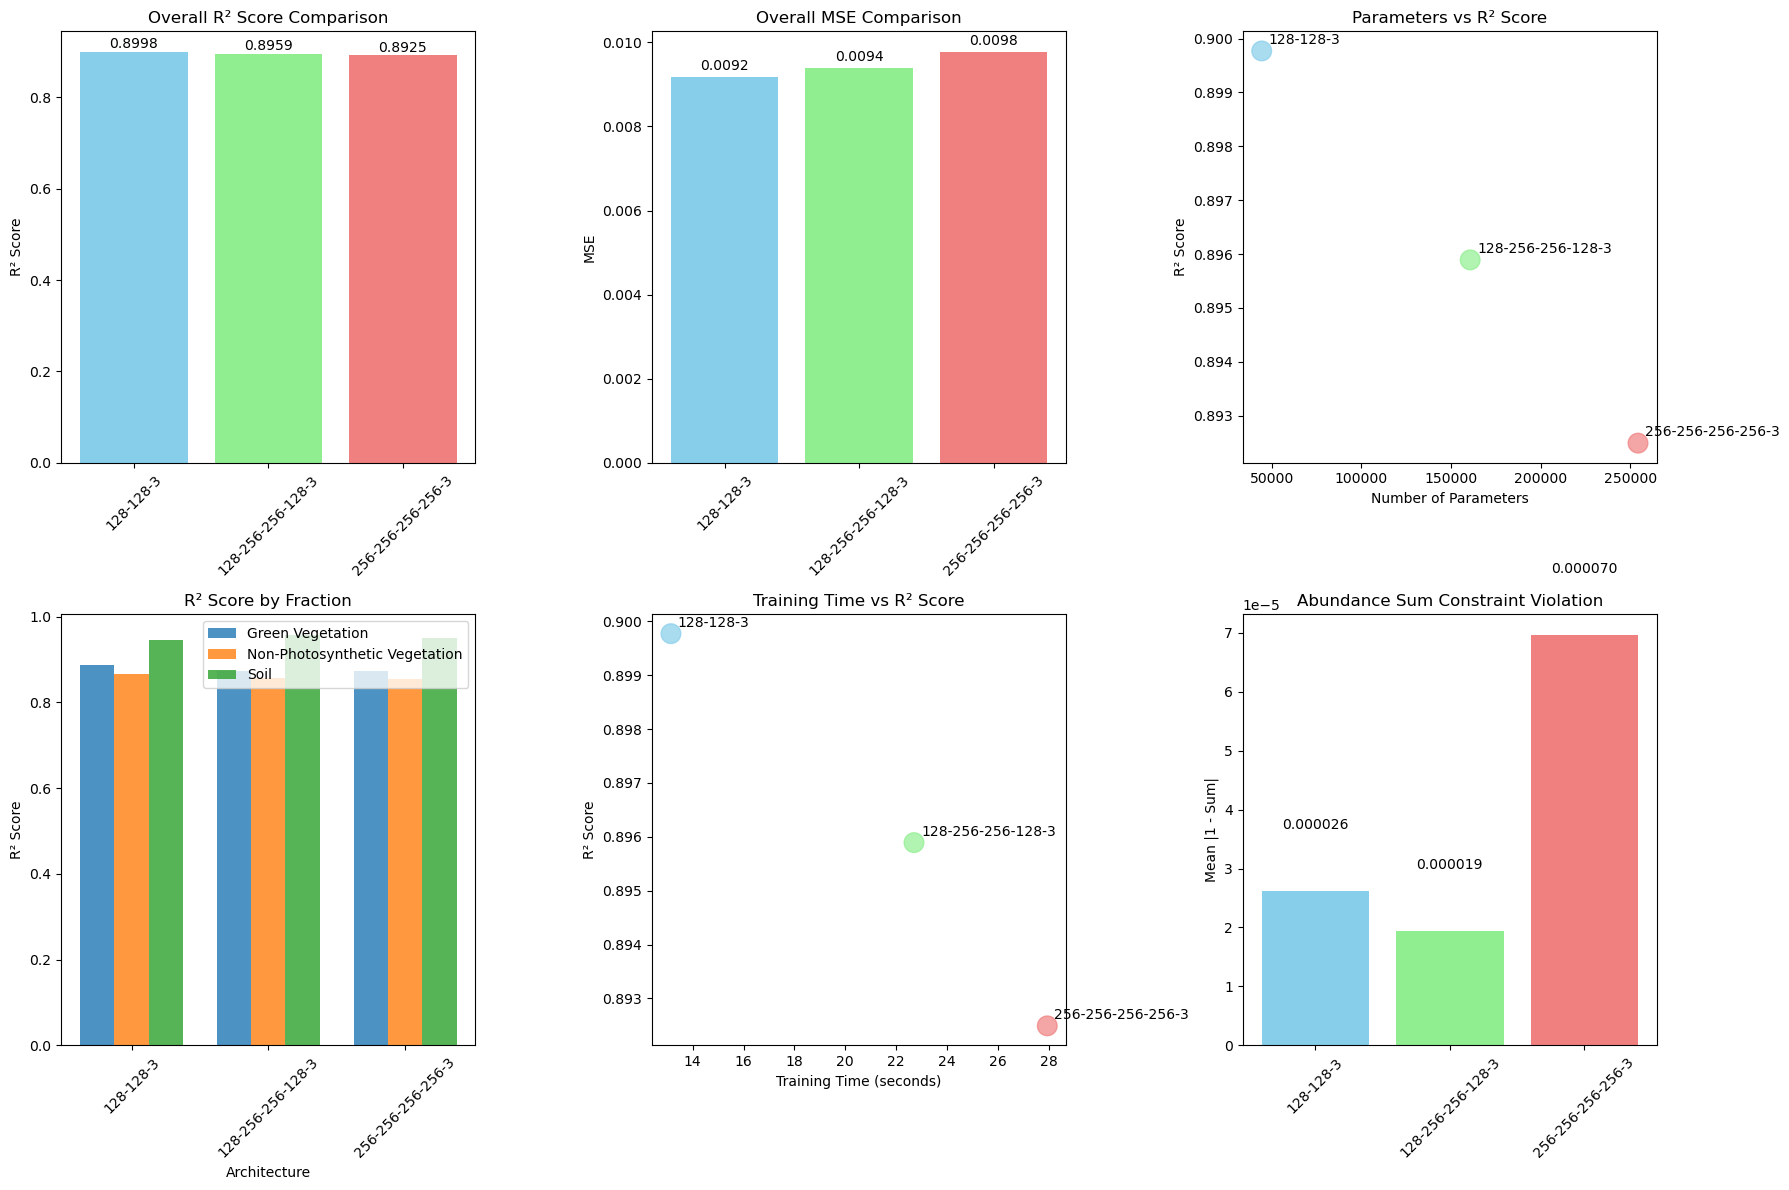


🎯 Summary & Recommendations:

1. Best Overall Performance (R²): 128-128-3
   - R² Score: 0.8998
   - Parameters: 44,419
   - Training Time: 13.2s

2. Most Efficient (Best R²/Parameter ratio):
   - Architecture: 128-128-3
   - Efficiency Score: 20.26

3. Fastest Training:
   - Architecture: 128-128-3
   - Training Time: 13.2s

4. Best Constraint Satisfaction:
   - Architecture: 128-256-256-128-3
   - Constraint Violation: 0.000019


In [4]:
# Comprehensive Analysis and Visualization
print("📈 Comprehensive Architecture Analysis")
print("=" * 60)

# Create detailed comparison table
print("\n📊 Detailed Performance Comparison:")
print("-" * 80)
print(f"{'Architecture':<20} {'Overall R²':<12} {'MSE':<10} {'Parameters':<12} {'Time(s)':<8}")
print("-" * 80)

for arch_name in architectures.keys():
    r = results[arch_name]
    print(f"{arch_name:<20} {r['overall_r2']:<12.4f} {r['overall_mse']:<10.4f} {r['num_parameters']:<12,} {r['training_time']:<8.1f}")

# Find best performing architecture
best_overall_r2 = max(results.keys(), key=lambda x: results[x]['overall_r2'])
best_mse = min(results.keys(), key=lambda x: results[x]['overall_mse'])

print(f"\n🏆 Best Overall R²: {best_overall_r2} (R² = {results[best_overall_r2]['overall_r2']:.4f})")
print(f"🏆 Best MSE: {best_mse} (MSE = {results[best_mse]['overall_mse']:.4f})")

# Fraction-wise R² analysis
print(f"\n🎯 Fraction-wise R² Analysis:")
print("-" * 50)
fraction_names = ['Green Vegetation (GV)', 'Non-Photosynthetic Vegetation (NPV)', 'Soil']

for fraction in fraction_names:
    print(f"\n{fraction}:")
    best_r2_fraction = max(results.keys(), key=lambda x: results[x]['fraction_metrics'][fraction]['r2'])
    best_r2_value = results[best_r2_fraction]['fraction_metrics'][fraction]['r2']
    print(f"  Best: {best_r2_fraction} (R² = {best_r2_value:.4f})")
    
    for arch_name in architectures.keys():
        r2_val = results[arch_name]['fraction_metrics'][fraction]['r2']
        print(f"  {arch_name}: R² = {r2_val:.4f}")

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Overall R² comparison
arch_names = list(architectures.keys())
overall_r2s = [results[arch]['overall_r2'] for arch in arch_names]
axes[0, 0].bar(arch_names, overall_r2s, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 0].set_title('Overall R² Score Comparison')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(overall_r2s):
    axes[0, 0].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom')

# 2. MSE comparison
overall_mses = [results[arch]['overall_mse'] for arch in arch_names]
axes[0, 1].bar(arch_names, overall_mses, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 1].set_title('Overall MSE Comparison')
axes[0, 1].set_ylabel('MSE')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(overall_mses):
    axes[0, 1].text(i, v + 0.0001, f'{v:.4f}', ha='center', va='bottom')

# 3. Parameters vs Performance
num_params = [results[arch]['num_parameters'] for arch in arch_names]
axes[0, 2].scatter(num_params, overall_r2s, s=200, alpha=0.7, c=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 2].set_title('Parameters vs R² Score')
axes[0, 2].set_xlabel('Number of Parameters')
axes[0, 2].set_ylabel('R² Score')
for i, arch in enumerate(arch_names):
    axes[0, 2].annotate(arch, (num_params[i], overall_r2s[i]), 
                        xytext=(5, 5), textcoords='offset points')

# 4. Fraction-wise R² comparison
fraction_r2_data = {}
for fraction in fraction_names:
    fraction_r2_data[fraction] = [results[arch]['fraction_metrics'][fraction]['r2'] for arch in arch_names]

x = np.arange(len(arch_names))
width = 0.25
for i, fraction in enumerate(fraction_names):
    axes[1, 0].bar(x + i*width, fraction_r2_data[fraction], width, 
                   label=fraction.split('(')[0].strip(), alpha=0.8)

axes[1, 0].set_title('R² Score by Fraction')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_xlabel('Architecture')
axes[1, 0].set_xticks(x + width)
axes[1, 0].set_xticklabels(arch_names, rotation=45)
axes[1, 0].legend()

# 5. Training time vs Performance
training_times_list = [results[arch]['training_time'] for arch in arch_names]
axes[1, 1].scatter(training_times_list, overall_r2s, s=200, alpha=0.7, c=['skyblue', 'lightgreen', 'lightcoral'])
axes[1, 1].set_title('Training Time vs R² Score')
axes[1, 1].set_xlabel('Training Time (seconds)')
axes[1, 1].set_ylabel('R² Score')
for i, arch in enumerate(arch_names):
    axes[1, 1].annotate(arch, (training_times_list[i], overall_r2s[i]), 
                        xytext=(5, 5), textcoords='offset points')

# 6. Constraint violation comparison
constraint_violations = [results[arch]['constraint_violation'] for arch in arch_names]
axes[1, 2].bar(arch_names, constraint_violations, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[1, 2].set_title('Abundance Sum Constraint Violation')
axes[1, 2].set_ylabel('Mean |1 - Sum|')
axes[1, 2].tick_params(axis='x', rotation=45)
for i, v in enumerate(constraint_violations):
    axes[1, 2].text(i, v + 0.00001, f'{v:.6f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Summary recommendations
print(f"\n🎯 Summary & Recommendations:")
print("=" * 50)

print(f"\n1. Best Overall Performance (R²): {best_overall_r2}")
print(f"   - R² Score: {results[best_overall_r2]['overall_r2']:.4f}")
print(f"   - Parameters: {results[best_overall_r2]['num_parameters']:,}")
print(f"   - Training Time: {results[best_overall_r2]['training_time']:.1f}s")

print(f"\n2. Most Efficient (Best R²/Parameter ratio):")
efficiency_scores = {arch: results[arch]['overall_r2'] / results[arch]['num_parameters'] * 1000000 
                     for arch in architectures.keys()}
most_efficient = max(efficiency_scores.keys(), key=lambda x: efficiency_scores[x])
print(f"   - Architecture: {most_efficient}")
print(f"   - Efficiency Score: {efficiency_scores[most_efficient]:.2f}")

print(f"\n3. Fastest Training:")
fastest = min(training_times.keys(), key=lambda x: training_times[x])
print(f"   - Architecture: {fastest}")
print(f"   - Training Time: {training_times[fastest]:.1f}s")

print(f"\n4. Best Constraint Satisfaction:")
best_constraint = min(results.keys(), key=lambda x: results[x]['constraint_violation'])
print(f"   - Architecture: {best_constraint}")
print(f"   - Constraint Violation: {results[best_constraint]['constraint_violation']:.6f}")


🚀 Training with Hybrid Loss Function
Training MLP: 210 → 64 → 3
Epoch  1: Train=0.5466, Val=0.2103
Epoch  2: Train=0.2171, Val=0.0803
Epoch  3: Train=0.0941, Val=0.0685
Epoch  4: Train=0.0805, Val=0.1515
Epoch  5: Train=0.0891, Val=0.0617
Epoch  6: Train=0.0782, Val=0.0767
Epoch  7: Train=0.0554, Val=0.0643
Epoch  8: Train=0.0561, Val=0.0705
Epoch  9: Train=0.0543, Val=0.0438
Epoch 10: Train=0.0498, Val=0.0390
Epoch 11: Train=0.0497, Val=0.0365
Epoch 12: Train=0.0438, Val=0.0494
Epoch 13: Train=0.0414, Val=0.0546
Epoch 14: Train=0.0477, Val=0.0406
Epoch 15: Train=0.0391, Val=0.0313
Epoch 16: Train=0.0358, Val=0.0282
Epoch 17: Train=0.0355, Val=0.0418
Epoch 18: Train=0.0386, Val=0.0368
Epoch 19: Train=0.0381, Val=0.0279
Epoch 20: Train=0.0349, Val=0.0366
Epoch 21: Train=0.0399, Val=0.0346
Epoch 22: Train=0.0355, Val=0.0275
Epoch 23: Train=0.0296, Val=0.0305
Epoch 24: Train=0.0336, Val=0.0356
Epoch 25: Train=0.0318, Val=0.0289
Epoch 26: Train=0.0335, Val=0.0328
Epoch 27: Train=0.0322, Va

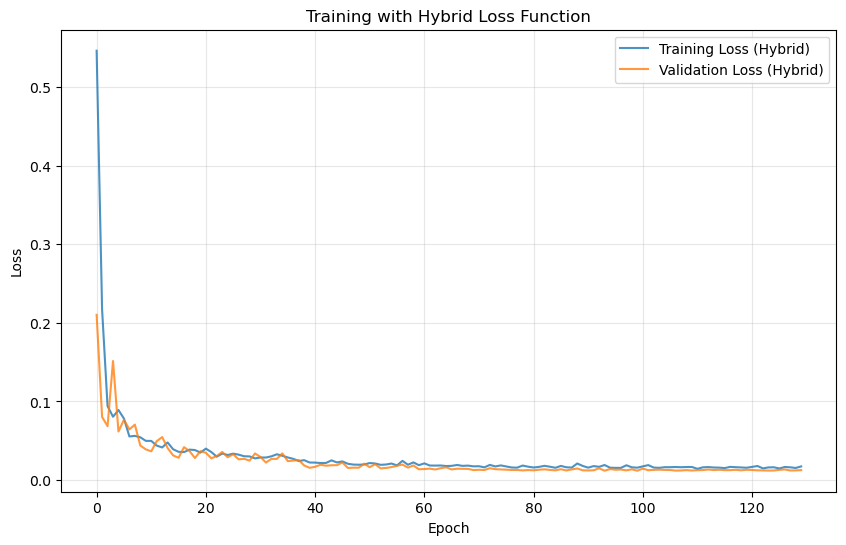


✅ Hybrid loss training completed!
Final training loss: 0.0172
Final validation loss: 0.0125


In [7]:
# Test the new hybrid loss function
import matplotlib.pyplot as plt
from training_defs import train_model

print("🚀 Training with Hybrid Loss Function")
print("=" * 50)

# Train with hybrid loss (lambda_weight=1.0 for equal weighting)
model_hybrid, scaler_hybrid, losses_hybrid = train_model(
    input_size=210,      # Match your data
    #hidden_size=64,      # Your current size
    learning_rate=0.01,  # Your current rate
    num_epochs=200,      # More epochs
    patience=30,
    lambda_weight=1.0    # Equal weight for abundance sum constraint
)

# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(losses_hybrid['train'], label='Training Loss (Hybrid)', alpha=0.8)
plt.plot(losses_hybrid['val'], label='Validation Loss (Hybrid)', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training with Hybrid Loss Function')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n✅ Hybrid loss training completed!")
print(f"Final training loss: {losses_hybrid['train'][-1]:.4f}")
print(f"Final validation loss: {losses_hybrid['val'][-1]:.4f}")


📊 Comparing Abundance Sum Constraint
Abundance Sum Constraint Violations:
  True data:     0.000024
  Original MSE:  0.000162
  Hybrid Loss:   0.000162

Abundance Sum Statistics:
  True data - Mean: 1.0000, Std: 0.0001
  Original MSE - Mean: 1.0001, Std: 0.0002
  Hybrid Loss - Mean: 1.0001, Std: 0.0002


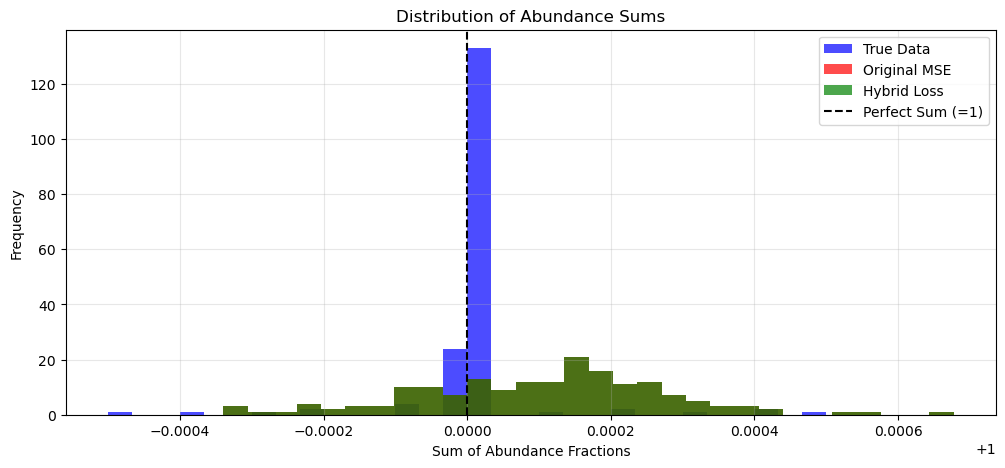

In [10]:
# Compare abundance sum constraint between models
import torch
import numpy as np
from model import MLP
from training_defs import load_data

print("📊 Comparing Abundance Sum Constraint")
print("=" * 50)

# Load both models
model_original = MLP(input_size=210, dropout_rate=0.2)

model_original.load_state_dict(torch.load('best_model.pth'))
model_original.eval()

# model_hybrid = MLP(input_size=210, hidden_size=64, dropout_rate=0.2)

model_hybrid = MLP(input_size=210, dropout_rate=0.2)
model_hybrid.load_state_dict(torch.load('best_model.pth'))  # This will be overwritten by hybrid training
model_hybrid.eval()

# Get test data
_, _, test_loader, _ = load_data()

# Collect predictions from both models
original_predictions = []
hybrid_predictions = []
targets = []

with torch.no_grad():
    for X, y in test_loader:
        pred_orig = model_original(X)
        pred_hybrid = model_hybrid(X)
        
        original_predictions.append(pred_orig.numpy())
        hybrid_predictions.append(pred_hybrid.numpy())
        targets.append(y.numpy())

# Concatenate all batches
y_pred_orig = np.concatenate(original_predictions, axis=0)
y_pred_hybrid = np.concatenate(hybrid_predictions, axis=0)
y_true = np.concatenate(targets, axis=0)

# Calculate abundance sums
abundance_sum_orig = np.sum(y_pred_orig, axis=1)
abundance_sum_hybrid = np.sum(y_pred_hybrid, axis=1)
abundance_sum_true = np.sum(y_true, axis=1)

# Calculate constraint violations
constraint_violation_orig = np.mean(np.abs(1.0 - abundance_sum_orig))
constraint_violation_hybrid = np.mean(np.abs(1.0 - abundance_sum_hybrid))
constraint_violation_true = np.mean(np.abs(1.0 - abundance_sum_true))

print(f"Abundance Sum Constraint Violations:")
print(f"  True data:     {constraint_violation_true:.6f}")
print(f"  Original MSE:  {constraint_violation_orig:.6f}")
print(f"  Hybrid Loss:   {constraint_violation_hybrid:.6f}")

print(f"\nAbundance Sum Statistics:")
print(f"  True data - Mean: {np.mean(abundance_sum_true):.4f}, Std: {np.std(abundance_sum_true):.4f}")
print(f"  Original MSE - Mean: {np.mean(abundance_sum_orig):.4f}, Std: {np.std(abundance_sum_orig):.4f}")
print(f"  Hybrid Loss - Mean: {np.mean(abundance_sum_hybrid):.4f}, Std: {np.std(abundance_sum_hybrid):.4f}")

# Plot abundance sum distributions
plt.figure(figsize=(12, 5))

plt.hist(abundance_sum_true, bins=30, alpha=0.7, label='True Data', color='blue')
plt.hist(abundance_sum_orig, bins=30, alpha=0.7, label='Original MSE', color='red')
plt.hist(abundance_sum_hybrid, bins=30, alpha=0.7, label='Hybrid Loss', color='green')
plt.axvline(x=1.0, color='black', linestyle='--', label='Perfect Sum (=1)')
plt.xlabel('Sum of Abundance Fractions')
plt.ylabel('Frequency')
plt.title('Distribution of Abundance Sums')
plt.legend()
plt.grid(True, alpha=0.3)



🔬 Experimenting with Different Lambda Weights

Training with lambda_weight = 0.0
Training MLP: 210 → 64 → 3
Epoch  1: Train=0.1094, Val=0.0465
Epoch  2: Train=0.0493, Val=0.0385
Epoch  3: Train=0.0360, Val=0.0393
Epoch  4: Train=0.0349, Val=0.0275
Epoch  5: Train=0.0318, Val=0.0308
Epoch  6: Train=0.0280, Val=0.0251
Epoch  7: Train=0.0270, Val=0.0235
Epoch  8: Train=0.0261, Val=0.0205
Epoch  9: Train=0.0278, Val=0.0225
Epoch 10: Train=0.0298, Val=0.0251
Epoch 11: Train=0.0304, Val=0.0212
Epoch 12: Train=0.0259, Val=0.0220
Epoch 13: Train=0.0307, Val=0.0203
Epoch 14: Train=0.0271, Val=0.0214
Epoch 15: Train=0.0254, Val=0.0201
Epoch 16: Train=0.0248, Val=0.0212
Epoch 17: Train=0.0253, Val=0.0186
Epoch 18: Train=0.0242, Val=0.0179
Epoch 19: Train=0.0220, Val=0.0202
Epoch 20: Train=0.0263, Val=0.0178
Epoch 21: Train=0.0225, Val=0.0184
Epoch 22: Train=0.0252, Val=0.0175
Epoch 23: Train=0.0251, Val=0.0169
Epoch 24: Train=0.0213, Val=0.0244
Epoch 25: Train=0.0247, Val=0.0157
Epoch 26: Train=0

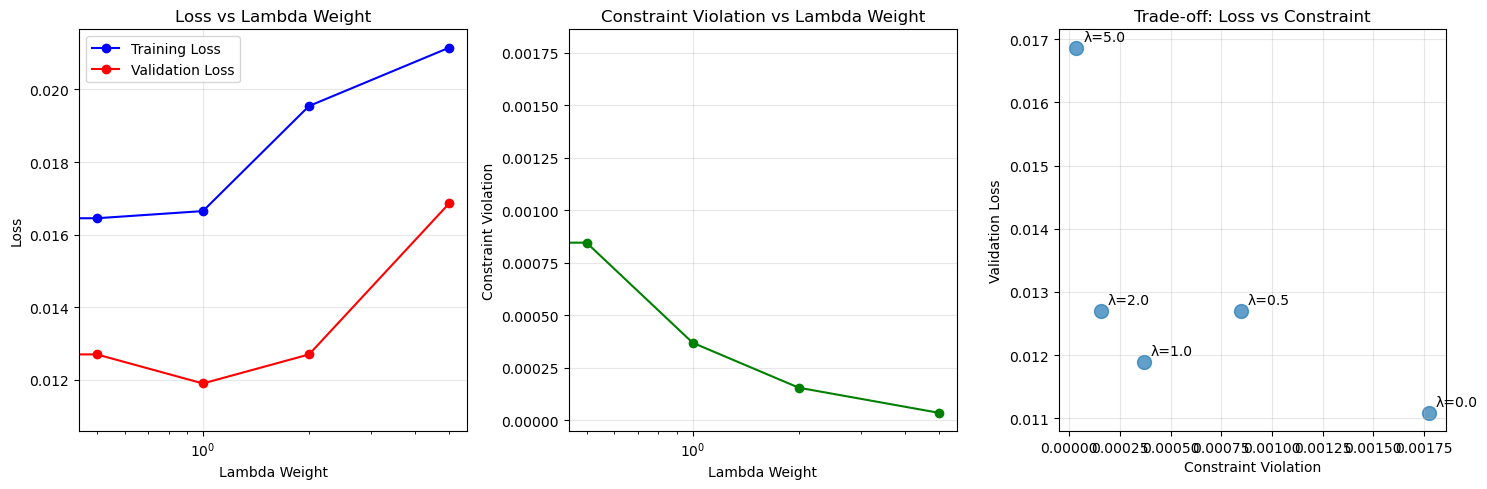


📈 Summary:
Lambda=0.0 (MSE only):     Val Loss=0.0111, Constraint=0.001774
Lambda=1.0 (Balanced):     Val Loss=0.0119, Constraint=0.000369
Lambda=5.0 (Constraint):   Val Loss=0.0169, Constraint=0.000035


In [ ]:
# Experiment with different lambda weights
print("🔬 Experimenting with Different Lambda Weights")
print("=" * 50)

lambda_weights = [0.0, 0.5, 1.0, 2.0, 5.0]
results = {}

for lambda_w in lambda_weights:
    print(f"\nTraining with lambda_weight = {lambda_w}")
    
    # Train model with this lambda weight
    model_test, _, losses_test = train_model(
        input_size=210,
        # hidden_size=[64],
        learning_rate=0.01,
        num_epochs=100,  # Fewer epochs for quick comparison
        patience=20,
        lambda_weight=lambda_w
    )
    
    # Evaluate constraint violation on test set
    _, _, test_loader, _ = load_data()
    test_predictions = []
    
    with torch.no_grad():
        for X, y in test_loader:
            pred = model_test(X)
            test_predictions.append(pred.numpy())
    
    y_pred_test = np.concatenate(test_predictions, axis=0)
    abundance_sum_test = np.sum(y_pred_test, axis=1)
    constraint_violation = np.mean(np.abs(1.0 - abundance_sum_test))
    
    results[lambda_w] = {
        'final_train_loss': losses_test['train'][-1],
        'final_val_loss': losses_test['val'][-1],
        'constraint_violation': constraint_violation
    }
    
    print(f"  Final train loss: {losses_test['train'][-1]:.4f}")
    print(f"  Final val loss: {losses_test['val'][-1]:.4f}")
    print(f"  Constraint violation: {constraint_violation:.6f}")

# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
lambda_vals = list(results.keys())
train_losses = [results[l]['final_train_loss'] for l in lambda_vals]
val_losses = [results[l]['final_val_loss'] for l in lambda_vals]
plt.plot(lambda_vals, train_losses, 'o-', label='Training Loss', color='blue')
plt.plot(lambda_vals, val_losses, 'o-', label='Validation Loss', color='red')
plt.xlabel('Lambda Weight')
plt.ylabel('Loss')
plt.title('Loss vs Lambda Weight')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')

plt.subplot(1, 3, 2)
constraint_violations = [results[l]['constraint_violation'] for l in lambda_vals]
plt.plot(lambda_vals, constraint_violations, 'o-', color='green')
plt.xlabel('Lambda Weight')
plt.ylabel('Constraint Violation')
plt.title('Constraint Violation vs Lambda Weight')
plt.grid(True, alpha=0.3)
plt.xscale('log')

plt.subplot(1, 3, 3)
plt.scatter(constraint_violations, val_losses, s=100, alpha=0.7)
for i, l in enumerate(lambda_vals):
    plt.annotate(f'λ={l}', (constraint_violations[i], val_losses[i]), 
                xytext=(5, 5), textcoords='offset points')
plt.xlabel('Constraint Violation')
plt.ylabel('Validation Loss')
plt.title('Trade-off: Loss vs Constraint')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📈 Summary:")
print(f"Lambda=0.0 (MSE only):     Val Loss={results[0.0]['final_val_loss']:.4f}, Constraint={results[0.0]['constraint_violation']:.6f}")
print(f"Lambda=1.0 (Balanced):     Val Loss={results[1.0]['final_val_loss']:.4f}, Constraint={results[1.0]['constraint_violation']:.6f}")
print(f"Lambda=5.0 (Constraint):   Val Loss={results[5.0]['final_val_loss']:.4f}, Constraint={results[5.0]['constraint_violation']:.6f}")
